# Natural Language Processing. Assignment 1. Tokenization.

In this assignment, you need to implement, train, and analyze a Byte-Pair Encoding (BPE) tokenizer.

The assignment consist of 3 tasks. When you finish all the tasks, create a GitHub repository for this assignment (you can use this repository later for the other assignments) and submit this notebook in the repository. Leave `requirements.txt` file if your code requires additional installations. Submit the link to the repository in Moodle.

## Task 1: Data Preparation and Vocabulary Size Selection (3 points)

First, load the [Brown corpus](https://en.wikipedia.org/wiki/Brown_Corpus). After loading the corpus, you need to select the appropriate vocabulary size for the BPE tokenizer. The appropriate vocabulary size is the minimal vocabulary size that covers at least 90% of the words in the corpus. The coverage is calculated according to the following formula:



$$ \text{coverage}(k) = \frac{\sum_{r=1}^{k} f(r)}{\sum_{r=1}^{N} f(r)} $$



where $f(r)$ is the frequency of the top-$r$ word, $k$ is the number of top-$k$ tokens included in vocab, $N$ is the total unique words in corpus.

So, for this task you need to do the following:

1. Load the Brown corpus (0.5 points)
2. Plot cumulative coverage vs. vocabulary size for the loaded corpus (1 point)
3. Select the appropriate vocabulary size (0.5 point)
4. Answer the questions:
    1. Why the coverage slows down the increase as the vocabulary size increases? (0.5 point)
    2. Which empirical law explains the slowing down increase of the coverage? (0.5 point)

In [1]:
import nltk

nltk.download('brown')

[nltk_data] Downloading package brown to /Users/m3/nltk_data...
[nltk_data]   Package brown is already up-to-date!


True

In [2]:
# 1. Load Brown corpus
from nltk.corpus import brown
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import random

random.seed(42)

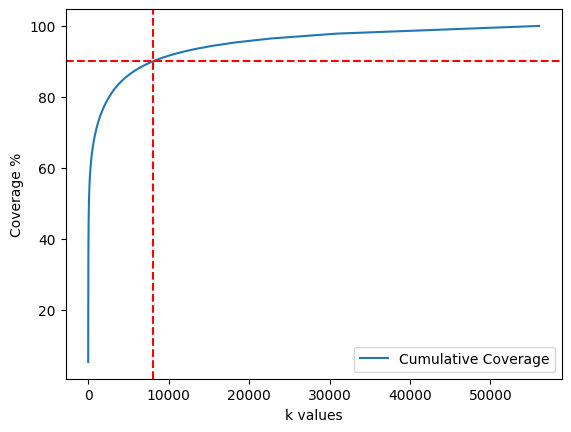

Appropriate vocabulary size: 8012 with 90.0005% coverage


In [3]:
# 2,3 Plot values and select appropriate vocabulary size
word_counts = Counter([word for word in brown.words()])
top_words = sorted(list(word_counts.values()), reverse=True)
n_unique = len(top_words)
n_total = len(brown.words())

k_values = np.arange(1, n_unique + 1, 1)
coverage_values = np.cumsum(top_words) / n_total * 100
vocab_size = np.argmax(coverage_values >= 90) + 1

plt.xlabel('k values')
plt.ylabel('Coverage %')
plt.plot(k_values, coverage_values, label='Cumulative Coverage')
plt.axhline(90, c='r', linestyle='--')
plt.axvline(vocab_size, c='r', linestyle='--')
plt.legend()
plt.show()
print(f'Appropriate vocabulary size: {vocab_size} with {coverage_values[vocab_size - 1]:.4f}% coverage')

### 4.1 Why the coverage slows down the increase as the vocabulary size increases?

Coverage slows down, because we start by adding most frequent tokens to the vocabulary (these "cover" a large portion of the corpus), then only low frequency tokens are left and they don't contribute to coverage as much.

### 4.2 Which empirical law explains the slowing down increase of the coverage?

Zipf's Law - frequency of an item is inversely proportional to its rank in the frequency table (later items don't contibute as much)


## Task 2: Implement Byte-Pair Encoding (BPE) Tokenizer (4 points)

Implement the [BPE tokenizer](https://arxiv.org/pdf/1508.07909) as the `BPETokenizer` class.

The class should contain correctly implemented:

* `train` method (1.5 points).
* `tokenize` method (1.5 points).

The code should have docstrings and comments (1 point).

In [4]:
from typing import List, Dict, Tuple
from tqdm.auto import tqdm
import regex as re
from collections import defaultdict
import heapq

class BPETokenizer:
    """
    Byte-Pair Encoding (BPE) tokenizer for UTF-8 bytes.
    """

    def __init__(self,):
        self.vocabulary = set(range(256))
        self.merges : List[Tuple[Tuple[int, int], int]] = []
        self.pattern = re.compile(r""" ?\p{L}+| ?\p{N}| ?[^\s\p{L}\p{N}]+|\s+""")
        self._next_id = 256


    def slow_train(self, corpus_sents: List[str], vocab_size: int):
        """
        Naive and slow implementation of BPE tokenizer training algorithm.
        It recomputes all pairs for each iteration.

        Args:
            corpus_sents: List of strings - sentences to train on.
            vocab_size: Desired vocabulary size.
        """
        word_list = []
        for sent in corpus_sents:
            word_list.extend(self.pattern.findall(sent))
        splits = [list(word.encode('utf-8')) for word in word_list]
        for i in tqdm(range(len(self.vocabulary), vocab_size), desc='Training', unit='pair'):
            pair_counts = self._get_pair_counts(splits)
            best_pair = max(pair_counts, key=pair_counts.get)
            self.merges[best_pair] = i
            self.vocabulary.add(i)
            splits = self._merge_pair(best_pair, splits)

    def _merge_pair(self, pair: Tuple[int, int], splits: List[List[int]]) -> List[List[int]]:
        """
        Merges pair of token IDs in the list of token splits.

        Args:
            pair: A tuple of two integers - token IDs to merge.
            splits: A list of sublists with token IDs.

        Returns:
            The modified list of token sequences after merging the pair.
        """
        a, b = pair
        for i in range(len(splits)):
            j = 0
            while j < len(splits[i]) - 1:
                if a == splits[i][j] and b == splits[i][j + 1]:
                    splits[i] = splits[i][:j] + [self.merges[pair]] + splits[i][j + 2:]
                else:
                    j += 1
        return splits

    def _get_pair_counts(self, splits: List[List[int]]) -> Dict[Tuple[int, int], int]:
        """
        Counts the frequency of each pair of consecutive token IDs in the splits.

        Args:
            splits: List of sublists with token IDs.

        Returns:
            A dictionary with pairs of token IDs as keys and their counts as values.
        """
        pair_counts = {}
        for split in splits:
            for i in range(len(split) - 1):
                pair = split[i], split[i + 1]
                pair_counts[pair] = pair_counts.get(pair, 0) + 1
        return pair_counts


    def train(self, corpus_sents: List[str], vocab_size: int) -> None:
        """
        Efficient implementation of BPE tokenizer training algorithm.
        It uses max-heap for pair selection.

        Args:
            corpus_sents: List of strings - sentences to train on.
            vocab_size: Desired vocabulary size.
        """
        # Split corpus into chunks for training
        word_list = []
        for sent in corpus_sents:
            word_list.extend(self.pattern.findall(sent))

        # Initialize id -> UFT-8 bytes mapping
        self.i2t = {i: bytes([i]) for i in range(256)}

        # Count how many times each chunk appears in corpus
        word_counts = Counter(word_list)

        # Store each unique word as a list of UTF-8 byte token ids
        word_tokens = {
            word: list(word.encode('utf-8')) for word in word_counts
        }

        # pair_counts: weighted frequency of each adjacent token pair
        # p2w: reverse index from pair -> set(words containing that pair)
        pair_counts = Counter()
        p2w = defaultdict(set)
        for word, tokens in word_tokens.items():
            if len(tokens) < 2:
                continue

            word_count = word_counts[word]
            for a, b in zip(tokens, tokens[1:]):
                pair_counts[(a, b)] += word_count
                p2w[(a, b)].add(word)

        # Max-heap to retrieve most frequent pair
        heap = []
        for pair, count in pair_counts.items():
            heapq.heappush(heap, (-count, pair))

        total_merges = vocab_size - len(self.vocabulary)
        pbar = tqdm(total=total_merges, desc='Training', unit='pair')
        
        # Repeat until target vocab size or no valid pair remains
        while self._next_id < vocab_size and heap:
            best_count, best_pair = heapq.heappop(heap)
            best_count = -best_count

            # Skip entries with updated counts
            if pair_counts.get(best_pair, 0) != best_count:
                continue
            if best_count == 0:
                break

            # Create new merged token ID for current best pair
            new_id = self._next_id
            self._next_id += 1
            self.vocabulary.add(new_id)
            self.merges.append((best_pair, new_id))
            self.i2t[new_id] = self.i2t[best_pair[0]] + self.i2t[best_pair[1]]

            # Only words containing best_pair can change
            affected_words = list(p2w.get(best_pair, set()))
            if not affected_words:
                pair_counts[best_pair] = 0
                continue

            a, b = best_pair

            for word in affected_words:
                prev = word_tokens[word]
                if len(prev) < 2:
                    continue
                count = word_counts[word]

                # Remove previous pair contributions for this word
                for pair in set(zip(prev, prev[1:])):
                    pair_counts[pair] -= count
                    p2w[pair].discard(word)

                # Apply the merge (a, b) -> new_id across this word token sequence
                merged = []
                i = 0
                while i < len(prev):
                    if i < len(prev) - 1 and prev[i] == a and prev[i + 1] == b:
                        merged.append(new_id)
                        i += 2
                    else:
                        merged.append(prev[i])
                        i += 1

                # Save updated tokenization for this word
                word_tokens[word] = merged

                # Add new pair contributions after merge
                if len(merged) >= 2:
                    new_pairs = list(zip(merged, merged[1:]))
                    for p in new_pairs:
                        pair_counts[p] += count
                        p2w[p].add(word)

            # best_pair is resolved
            pair_counts[best_pair] = 0
            p2w[best_pair].clear()

            # Push updated pair counts from affected words back into heap
            for word in affected_words:
                tokens = word_tokens[word]
                for p in zip(tokens, tokens[1:]):
                    c = pair_counts.get(p, 0)
                    if c > 0:
                        heapq.heappush(heap, (-c, p))

            pbar.update(1)

        pbar.close()

    def tokenize(self, text: str) -> List[int]:
        """
        Tokenizes text into token IDs.
        Applies learned merges in training order.

        Args:
            text: Input string to tokenize.

        Returns:
            A list of token IDs.
        """
        tokens = list(text.encode('utf-8'))

        for (a, b), new_id in self.merges:
            result = []
            i = 0
            while i < len(tokens):
                if i < len(tokens) - 1 and tokens[i] == a and tokens[i + 1] == b:
                    result.append(new_id)
                    i += 2
                else:
                    result.append(tokens[i])
                    i += 1
            tokens = result

        return tokens

    def decode_to_list(self, ids: List[int]) -> List[str]:
        """
        Converts a sequence of token IDs into a list of decoded string tokens.

        Args:
            ids: List of integer token IDs.

        Returns:
            List[str]: Decoded token strings.
        """
        tokens = []
        for idx in ids:
            token_bytes = self.i2t[idx]
            
            token_str = token_bytes.decode('utf-8', errors='replace')
            tokens.append(token_str)
            
        return tokens

/Users/m3/Documents/uni/s26/nlp/s26-nlp-assignments/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Task 3: Tokenizer Training and Analysis (3 points)

1. Train the `BPETokenizer` on the Brown corpus with the appropriate vocabulary size selected in Task 1 (1 points)
2. Use the Brown corpus (1000 samples) to calculate the mean and standard deviation of
    * tokenizer's fertility (1 points)
    * length of the tokenized sentence (1 points)

In [5]:
# Restore sentences with correct whitespace placements for "proper" tokenization
def brown_fix(tokens):
    no_space_before = {'.', ',', '!', '?', ':', ';', ')', ']', '}', "''"}
    no_space_after = {'(', '[', '{', '``'}
    
    result = tokens[0]
    for i in range(1, len(tokens)):
        if tokens[i] in no_space_before or tokens[i - 1] in no_space_after:
            result += tokens[i]
        else:
            result += " " + tokens[i]
    return result

fix_sents = []
for sent in brown.sents():
    fix_sents.append(brown_fix(sent))

fix_sents[:5]

["The Fulton County Grand Jury said Friday an investigation of Atlanta's recent primary election produced ``no evidence'' that any irregularities took place.",
 "The jury further said in term-end presentments that the City Executive Committee, which had over-all charge of the election, ``deserves the praise and thanks of the City of Atlanta'' for the manner in which the election was conducted.",
 "The September-October term jury had been charged by Fulton Superior Court Judge Durwood Pye to investigate reports of possible ``irregularities'' in the hard-fought primary which was won by Mayor-nominate Ivan Allen Jr..",
 "``Only a relative handful of such reports was received'', the jury said, ``considering the widespread interest in the election, the number of voters and the size of this city''.",
 "The jury said it did find that many of Georgia's registration and election laws ``are outmoded or inadequate and often ambiguous''."]

In [6]:
# 1. Training
tokenizer = BPETokenizer()
tokenizer.train(fix_sents, vocab_size)

Training: 100%|██████████| 7756/7756 [00:05<00:00, 1458.83pair/s]


In [7]:
lengths = []
fertilities = []
data = random.sample(list(zip(fix_sents, brown.sents())), 1000)

for sent, sent_words in tqdm(data, desc='Analyzing', unit='sent'):
    
    tokens = tokenizer.tokenize(sent)
    
    num_tokens = len(tokens)
    num_words = len(sent_words)
    
    lengths.append(num_tokens)
    fertilities.append(num_tokens / num_words if num_words > 0 else 0)

# 2. Metrics
mean_fert = np.mean(fertilities)
std_fert = np.std(fertilities)

mean_len = np.mean(lengths)
std_len = np.std(lengths)

print(f"Tokenized Length: Mean = {mean_len:.2f}, Std = {std_len:.2f}")
print(f"Fertility:        Mean = {mean_fert:.2f}, Std = {std_fert:.2f}")

Analyzing: 100%|██████████| 1000/1000 [00:11<00:00, 89.78sent/s]

Tokenized Length: Mean = 26.14, Std = 18.80
Fertility:        Mean = 1.30, Std = 0.28


## Grading Procedure Details

During the grading of the completed assignments, a random set of students will be sampled for the **offline assignment defence**. The defence will be arranged shortly after the assignment submission deadline. The particular date and time will be announced later. 

The aim of the assignment defence is to ensure the students understand well their own solutions and know how thier solution works. To check this, the students will be asked various questions about the provided solution. In addition, the students will be asked to run their solution to ensure the solution works without errors.

Examples of questions:

1. How the cumulative coverage is calculated? Why is it called cumulative?
2. What is the rank of a word?
3. How does the BPE tokenizer work? Note: for this question, the students will not be able to see the their own implementation.
4. Why do you consider such vocabulary size appropriate?
5. What is the formula for the fertility of the tokenizer?
6. How do you perform pre-tokenization in your implementation?
7. How do you handle stopwords in the training corpus? Why?
8. etc.

As a result of the assignment defence, the grade for the assignment may be adjusted.